## Currently Data

In [1]:
import covid_mx ## function and packages
# grid search model
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from numpy import array
# Python Data Analysis imports
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import pandas.plotting as pp

# Visualisation imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
# %matplotlib inline
# plt.style.use('fivethirtyeight')
from tabulate import tabulate

# statistics
from statsmodels.tsa.api import Holt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
## Load Data
df = covid_mx.load_data()
## specific column to analyze
dfObj = covid_mx.prepare_data(df,'Confirmed')

# Confirmed cases in México (Daily)

## CRISP-DM

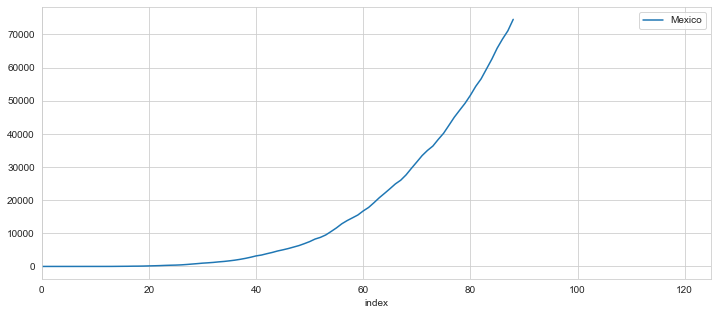

In [3]:
# Plotting Days in México "confirmed cases"
country = 'Mexico'
dfObj[country].plot(legend=True,figsize=(12,5))

## Model

In [4]:
## Subset Mexico and the world,  same pandemic days
df_mx = dfObj[country]
# Drop rows with missing Confirmed values
df_mx = df_mx.dropna()
# df_mx.index.max()


In [5]:
## Days
print(df_mx.index.max())

88


In [6]:
# https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/ 
data = pd.Series(df_mx).values
data = data.astype('double')
n_test = 5
cfg_list = covid_mx.exp_smoothing_configs()

In [7]:
scores = covid_mx.grid_search(data, cfg_list, n_test)

 > Model[[None, False, None, None, True, True]] 2265.795
 > Model[['add', False, None, None, True, True]] 523.154
 > Model[[None, False, None, None, True, False]] 3019.794
 > Model[[None, False, None, None, False, True]] 2274.527
 > Model[[None, False, None, None, False, False]] 3019.794
 > Model[['add', False, None, None, True, False]] 522.007
 > Model[['add', False, None, None, False, True]] 508.921
 > Model[['add', False, None, None, False, False]] 515.310
 > Model[['add', True, None, None, False, False]] 515.309
 > Model[['add', True, None, None, False, True]] 508.921
 > Model[['add', True, None, None, True, False]] 793.531
 > Model[['add', True, None, None, True, True]] 681.621
 > Model[['mul', True, None, None, False, True]] 400.844
 > Model[['mul', True, None, None, False, False]] 388.147
 > Model[['mul', False, None, None, False, True]] 482.998
 > Model[['mul', False, None, None, False, False]] 491.132


In [8]:
for cfg, error in scores[:3]:
        print(cfg, error)

['mul', True, None, None, False, False] 388.1474324915667
['mul', True, None, None, False, True] 400.84354514349553
['mul', False, None, None, False, True] 482.99792629866494


## Forecast

In [9]:
## Best
model = ExponentialSmoothing(pd.Series(data), 
                             trend='mul', damped=True, seasonal=None, seasonal_periods=None)
# fit model
model = model.fit(optimized=True, use_boxcox=False, remove_bias=False)

/Users/jamancilla/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [10]:
print(model.summary().tables[1])

                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_slope            0.0702167                 beta                 True
initial_level              11.835961                  l.0                 True
initial_slope               0.000000                  b.0                 True
damping_slope              0.9818060                  phi                 True
------------------------------------------------------------------------------


In [11]:
print(pd.Series(model.forecast(10)).round())

89     77681.0
90     80873.0
91     84134.0
92     87463.0
93     90860.0
94     94324.0
95     97853.0
96    101446.0
97    105102.0
98    108820.0
dtype: float64


Fg: Cases in Mexico Forecast.


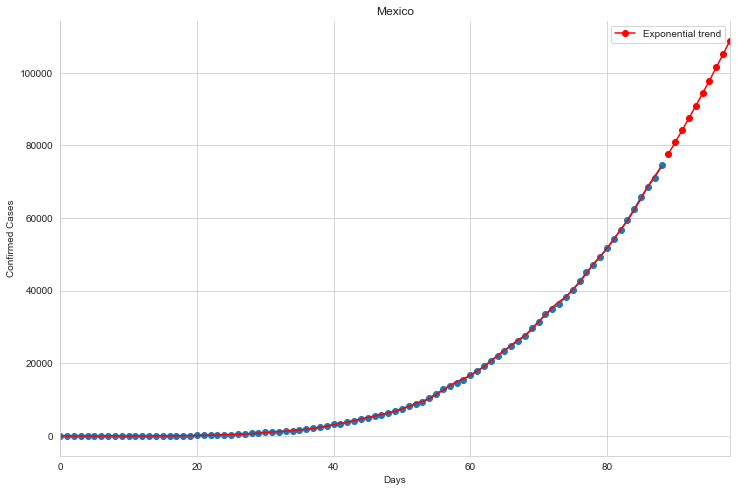

In [12]:
fcast = pd.Series(model.forecast(10)).rename("Exponential trend")
print("Fg: Cases in Mexico Forecast.")
ax = pd.Series(data).plot( marker="o", figsize=(12,8)) # color="blue",
pd.Series(model.fittedvalues).plot(ax=ax, color='red')
fcast.plot(ax=ax, color='red', marker="o", legend=True)
ax.set_title("Mexico")
ax.set_xlabel("Days")
ax.set_ylabel("Confirmed Cases")
ax.spines["top"].set_alpha(0)
plt.show()
